In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/train.csv", parse_dates=['date'])
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [2]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [3]:
df.isnull().sum()


date     0
store    0
item     0
sales    0
dtype: int64

In [4]:
df = df[df['sales'] < df['sales'].quantile(0.99)]


In [5]:
df = df.sort_values(['store', 'item', 'date'])


In [11]:
df.to_csv("../data/processed/cleaned_data.csv", index=False)


In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# Sort and group by store-item
df = df.sort_values(['store', 'item', 'date'])
df['lag_1'] = df.groupby(['store','item'])['sales'].shift(1)
df['lag_7'] = df.groupby(['store','item'])['sales'].shift(7)
df['rolling_mean_7'] = df.groupby(['store','item'])['sales'].shift(1).rolling(7).mean()
df['rolling_mean_30'] = df.groupby(['store','item'])['sales'].shift(1).rolling(30).mean()

df = df.dropna()


In [15]:
df.to_csv("../data/processed/feature_data.csv", index=False)


In [16]:
train = df[df['date'] < '2017-01-01']
test = df[df['date'] >= '2017-01-01']

X_train = train.drop(['sales', 'date'], axis=1)
y_train = train['sales']
X_test = test.drop(['sales', 'date'], axis=1)
y_test = test['sales']


In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


MAE: 5.93, RMSE: 7.64, MAPE: 12.64%


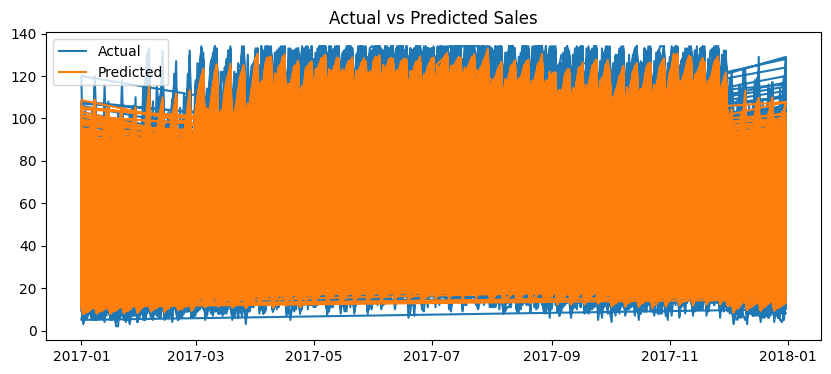

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(test['date'], y_test.values, label="Actual")
plt.plot(test['date'], y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()


In [23]:
import joblib, json

joblib.dump(model, "../models/model.pkl")

metrics = {"mae": mae, "rmse": rmse, "mape": mape}
with open("../models/metrics.json", "w") as f:
    json.dump(metrics, f)
